In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image

import sys
sys.path.append('./')
from utils import Dummyfier, prepare, evaluate_clf, uplift

from IPython.core.debugger import set_trace

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
test = pd.read_csv('./test_data/test_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE', 'START_DATE'])
print('Dataset size: ', test.shape)
test = test.set_index(['CONTRACT_REF', 'CLIENT_ID'])
test.head(2)

Dataset size:  (92691, 212)


,,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
CONTRACT_REF,CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
271-P-65145100,113314732,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1986-12-29,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
271-P-62910309,102105734,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1968-03-11,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [4]:
train = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', train.shape)
train.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train['TARGET'].value_counts(normalize=True)

0    0.955483
1    0.044517
Name: TARGET, dtype: float64

In [6]:
train.groupby('CONTROL_GROUP_FLG').mean()[['TARGET']]

,TARGET
CONTROL_GROUP_FLG,
N,0.047636
Y,0.026921


In [7]:
dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']
d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

y_train = Xy_train['TARGET'].values.flatten()

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME_UNI', 'START_DATE']
X_train = Xy_train.drop(['TARGET'] + identity, axis=1)


X_test = prepare(test)
X_test = d.transform(X_test)

na_cols_test = X_test.isna().any()
na_cols_test = na_cols_test[na_cols_test==True].index.tolist()
X_test = X_test.fillna(value=X_test[na_cols_test].mean())

X_test = X_test.drop('START_DATE', axis=1)
X_test['CONTROL_GROUP_FLG'] = 0

X_test = X_test[X_train.columns.tolist()]

In [8]:
scaler = StandardScaler()

X_train_sc = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_sc_tg = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_test['CONTROL_GROUP_FLG'] = 1
X_test_sc_cg = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# 1 Построение одной модели для тестовой и контрольной групп

In [9]:
%%time

lr = LogisticRegression().fit(X_train_sc, y_train)

test['LR_ONE'] = lr.predict_proba(X_test_sc_tg)[:, 1] - lr.predict_proba(X_test_sc_cg)[:, 1]

Wall time: 11.5 s


In [10]:
import xgboost as xgb

boost = xgb.XGBClassifier().fit(X_train_sc, y_train)

test['XGB_ONE'] = boost.predict_proba(X_test_sc_tg)[:, 1] - boost.predict_proba(X_test_sc_cg)[:, 1]

C:\Users\SHevchenkoM\Program_files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2 Построение двух моделей

In [11]:
X_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1]['TARGET'].values.flatten()

X_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0]['TARGET'].values.flatten()

In [12]:
scaler_c = StandardScaler()

X_train_c_sc = pd.DataFrame(
    scaler_c.fit_transform(X_train_c),
    columns=X_train_c.columns,
    index=X_train_c.index
)

X_test_c_sc = pd.DataFrame(
    scaler_c.transform(X_test.drop(['CONTROL_GROUP_FLG'], axis=1)),
    columns=X_test.drop(['CONTROL_GROUP_FLG'], axis=1).columns,
    index=X_test.drop(['CONTROL_GROUP_FLG'], axis=1).index
)

In [13]:
lr_c = LogisticRegression().fit(X_train_c_sc, y_train_c)

In [14]:
boost_c = xgb.XGBClassifier(learning_rate=0.02).fit(X_train_c_sc, y_train_c)

In [15]:
scaler_t = StandardScaler()

X_train_t_sc = pd.DataFrame(
    scaler_t.fit_transform(X_train_t),
    columns=X_train_t.columns,
    index=X_train_t.index
)

X_test['CONTROL_GROUP_FLG'] = 0
X_test_t_sc = pd.DataFrame(
    scaler_t.transform(X_test.drop(['CONTROL_GROUP_FLG'], axis=1)),
    columns=(X_test.drop(['CONTROL_GROUP_FLG'], axis=1)).columns,
    index=(X_test.drop(['CONTROL_GROUP_FLG'], axis=1)).index
)

In [16]:
lr_t = LogisticRegression().fit(X_train_c_sc, y_train_c)

In [17]:
boost_t = xgb.XGBClassifier(learning_rate=0.02).fit(X_train_c_sc, y_train_c)

In [18]:
test['LR_TWO'] = lr_t.predict_proba(X_test_t_sc)[:, 1] - lr_c.predict_proba(X_test_c_sc)[:, 1]
test['XGB_TWO'] = boost_t.predict_proba(X_test_t_sc)[:, 1] - boost_c.predict_proba(X_test_c_sc)[:, 1]

# 3 Подход "Class Modification"

In [19]:
Xy_train_modify = pd.concat([
    Xy_train[Xy_train['CONTROL_GROUP_FLG']==0].sample(
        n=Xy_train[Xy_train['CONTROL_GROUP_FLG']==1].shape[0],
        random_state=555),
    Xy_train[Xy_train['CONTROL_GROUP_FLG']==1]
])

In [20]:
Xy_train_modify['modified_outcome'] = Xy_train_modify['TARGET'] *  (1 - Xy_train_modify['CONTROL_GROUP_FLG']) \
                                 + (1 - Xy_train_modify['TARGET']) * Xy_train_modify['CONTROL_GROUP_FLG']

In [21]:
y_train_modify = Xy_train_modify['modified_outcome'].values.flatten()
X_train_modify = Xy_train_modify.drop(['TARGET', 'modified_outcome', 'CONTROL_GROUP_FLG'] + identity, axis=1)

In [22]:
scaler = StandardScaler()

X_train_modify_sc = pd.DataFrame(
    scaler.fit_transform(X_train_modify),
    columns=X_train_modify.columns,
    index=X_train_modify.index
)

X_test_sc = pd.DataFrame(
    scaler.transform(X_test.drop(['CONTROL_GROUP_FLG'], axis=1)),
    columns=X_test.drop(['CONTROL_GROUP_FLG'], axis=1).columns,
    index=X_test.drop(['CONTROL_GROUP_FLG'], axis=1).index
)

In [23]:
lr_m = LogisticRegression().fit(X_train_modify_sc, y_train_modify)
boost_m = xgb.XGBClassifier(learning_rate=0.02).fit(X_train_modify_sc, y_train_modify)

In [24]:
test['LR_MOD'] = 2*(lr_m.predict_proba(X_test_sc)[:, 1]) - 1
test['XGB_MOD'] = 2*(boost_m.predict_proba(X_test_sc)[:, 1]) - 1

In [25]:
test.head()

,,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180,LR_ONE,XGB_ONE,LR_TWO,XGB_TWO,LR_MOD,XGB_MOD
CONTRACT_REF,CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
271-P-65145100,113314732,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1986-12-29,1,...,0.0,0.0,0,0.0,0.037820,0.018062,-0.001240,0.025439,0.297749,0.105852
271-P-62910309,102105734,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1968-03-11,1,...,0.0,0.0,0,0.0,0.007612,0.003817,-0.000068,0.013786,0.290125,-0.142399
274-P-25927584,101702538,МОНЧЕГОРСК,RU,МОНЧЕГОРСК,RU,МОНЧЕГОРСК,RU,0.0,BBKK,1959-12-23,1,...,0.0,0.0,0,0.0,0.003288,0.002642,-0.000024,0.025439,0.194109,-0.135728
272-P-27516819,104340886,КУДЬМА,RU,КУДЬМА,RU,КУДЬМА,RU,0.0,BBKK,1958-02-24,1,...,0.0,0.0,0,0.0,0.001586,0.001998,-0.000011,0.025439,-0.020901,-0.296702
271-P-69691662,107356656,NaN,NaN,NaN,NaN,NaN,NaN,7.0,BBKK,1985-03-26,1,...,0.0,0.0,0,0.0,0.010041,0.006360,-0.000435,0.013786,0.279651,-0.179857


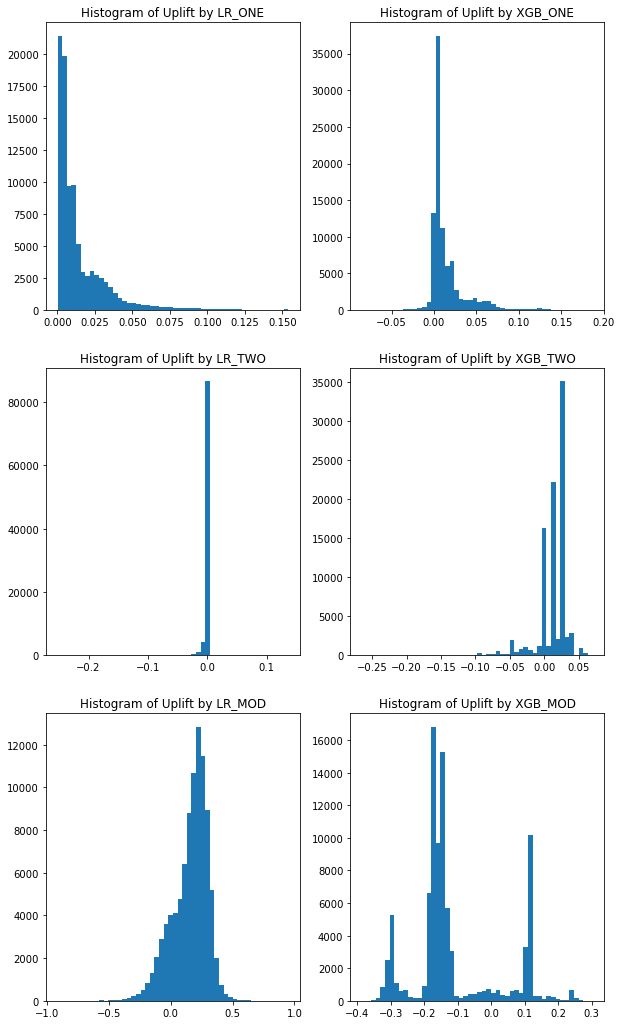

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(10, 18))

hists = ['LR_ONE', 'XGB_ONE', 'LR_TWO', 'XGB_TWO', 'LR_MOD', 'XGB_MOD']

for i, h in enumerate(hists):
    axes[i // 2][i % 2].title.set_text('Histogram of Uplift by ' + h)
    axes[i // 2][i % 2].hist(test[h], bins=50)

In [28]:
test[hists].to_csv('result.csv')